# High-Ram Validation

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.

In [ ]:
import time
import numpy as np

# Lectura CSV

In [ ]:
import pandas as pd
df_spy = pd.read_csv('spy_options_call_output_all_mc_price_lsm.csv')

In [ ]:
# Ordenar cronológicamente el dataset
df_spy = df_spy.sort_values(by=['quote_date', 'expire_date'], ascending=True).reset_index(drop=True)

In [ ]:
# Verificar si esta ordenado correctamente
print(df_spy['quote_date'].head())
print(df_spy['quote_date'].tail())

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: quote_date, dtype: object
154836    2023-12-29
154837    2023-12-29
154838    2023-12-29
154839    2023-12-29
154840    2023-12-29
Name: quote_date, dtype: object


In [ ]:
df_spy.head()

,quote_date,expire_date,dte,underlying_last,strike,strike_distance,strike_distance_pct,c_last,c_bid,c_ask,...,dte_year,c_volume_log,c_volume_log_scaled,volume_zero,moneyness,iv_pct_rank,c_iv_min,iv_skew,spread_mid_price,mc_price
0,2020-01-02,2020-01-03,1.0,324.87,331.5,6.6,0.020,0.05,0.0,0.02,...,0.003968,2.708050,0.396255,0,0.980000,0.615385,0.07086,0.03798,2.0,0.002181
1,2020-01-02,2020-01-03,1.0,324.87,332.0,7.1,0.022,0.01,0.0,0.02,...,0.003968,1.945910,0.284735,0,0.978524,0.628205,0.07086,0.04462,2.0,0.003219
2,2020-01-02,2020-01-03,1.0,324.87,332.5,7.6,0.023,0.02,0.0,0.02,...,0.003968,3.688879,0.539775,0,0.977053,0.692308,0.07086,0.05172,2.0,0.001166
3,2020-01-02,2020-01-03,1.0,324.87,336.0,11.1,0.034,0.03,0.0,0.02,...,0.003968,4.304065,0.629792,0,0.966875,0.846154,0.07086,0.10017,2.0,0.000972
4,2020-01-02,2020-01-03,1.0,324.87,340.0,15.1,0.047,0.01,0.0,0.02,...,0.003968,0.693147,0.101425,0,0.955500,0.910256,0.07086,0.15350,2.0,0.000407


In [ ]:
df_spy.shape

(154841, 32)

# Features

In [ ]:
df_spy.groupby('anio').size()

,0
anio,
2020,31605
2021,40002
2022,40174
2023,43060


In [ ]:
# Test data
df_spy_2023 = df_spy[df_spy['anio'] == 2023]

In [ ]:
# Train data
df_spy = df_spy[df_spy['anio'] < 2023]

In [ ]:
# target_train = 'c_mid_price'
# target_test = 'c_last'
# MAE: 0.6235434835084429
# RMSE: 2.648048019022547
# R²: 0.9926071365933151

features_cols = [
                 # Variables Black Scholes (captura el comportamiento teorico del precio de la opcion)
                 'moneyness', # contiene a 'underlying_last' y 'strike'
                 'dte_year',
                 'c_iv',
                  # Variables que capturan micro-comportamientos del precio real de la opcion (utilizando 'c_mid_price' en periodo de entrenamiento)
                 'iv_skew',
                 'iv_pct_rank',
                 'c_volume_log_scaled', # volumen y liquidez
                 # Indicadores Greeks (aportan estructura del modelo BS)
                 'c_delta',
                 'c_gamma',
                 'c_vega',
                 'c_theta',
                 'mc_price' # Monte Carlo Simulation Price
                  ]

Manten tu esquema:
- target_train = c_mid_price (mas estable al momento de entrenar)
- target_test = c_last (testear con valores reales del mercado)

Ese esquema es excelente y es exactamente lo que usan:
- market makers
- modelos basados en BS/Heston
- desk de volatilidad

In [ ]:
# target_train = 'c_last' # Para predecir el precio real transado de una opcion (Hacer un modelo robusto a mercado real, existe mucho mas ruido del mercado)
target_train = 'c_mid_price' # Para predecir (modelar) el precio teorico justo o replicar Black-Scholes
target_test = 'c_last'

In [ ]:
X = df_spy[features_cols]
y = df_spy[target_train]

In [ ]:
X_test_2023 = df_spy_2023[features_cols]
y_test_2023 = df_spy_2023[target_test]

In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


In [ ]:
X.describe()

,moneyness,dte_year,c_iv,iv_skew,iv_pct_rank,c_volume_log_scaled,c_delta,c_gamma,c_vega,c_theta,mc_price
count,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000
mean,1.043651,0.014947,0.458283,0.272342,0.414681,0.455260,0.586587,0.018097,0.059625,-0.156489,20.315838
std,0.131570,0.009988,0.471658,0.474468,0.279375,0.265914,0.408220,0.040045,0.060674,0.169203,29.226607
min,0.564118,0.000000,0.011770,-1.086930,0.001412,0.000000,0.000110,0.000000,0.000000,-0.999930,0.000000
25%,0.975635,0.007937,0.186720,0.016160,0.171053,0.214680,0.057780,0.001830,0.012920,-0.222150,0.318603
50%,1.020546,0.015873,0.281970,0.121470,0.366412,0.442098,0.817250,0.007230,0.037270,-0.100660,9.558985
75%,1.076613,0.023810,0.517200,0.327620,0.639731,0.673646,0.947600,0.023350,0.087920,-0.028200,27.765407
max,3.812400,0.031905,2.999450,2.961430,1.000000,1.000000,1.000000,1.603600,0.296900,-0.001620,287.605883


In [ ]:
print(df_spy['moneyness_category'].value_counts())
print(df_spy['moneyness_category'].value_counts(normalize=True)*100)

moneyness_category
ITM    69226
OTM    42544
ATM       11
Name: count, dtype: int64
moneyness_category
ITM    61.930024
OTM    38.060135
ATM     0.009841
Name: proportion, dtype: float64


In [ ]:
y.describe()

,c_mid_price
count,111781.000000
mean,19.708126
std,28.658286
min,0.010000
25%,0.175000
50%,8.940000
75%,27.050000
max,281.265000


In [ ]:
print("cantidad features:", X.shape[1])
print("cantidad target:", len(y.shape))

cantidad features: 11
cantidad target: 1


In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

## Entrenamiento

In [ ]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y

# transformamos el target con log1p
y_train_log = np.log1p(y_train)

In [ ]:
y_train.describe()

,c_mid_price
count,111781.000000
mean,19.708126
std,28.658286
min,0.010000
25%,0.175000
50%,8.940000
75%,27.050000
max,281.265000


In [ ]:
y_train_log.describe()

,c_mid_price
count,111781.000000
mean,2.026097
std,1.561906
min,0.009950
25%,0.161268
50%,2.296567
75%,3.333989
max,5.642846


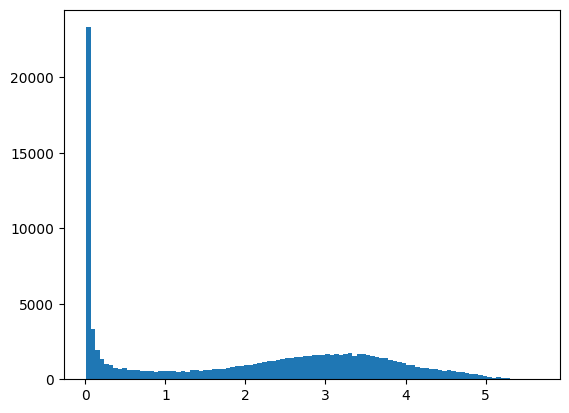

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_log, bins=100);

In [ ]:
print(f"Cantidad Registros para X_train: {X_train.shape[0]}")

Cantidad Registros para X_train: 111781


In [ ]:
print(f"Cantidad Registros para X_test_2023: {X_test_2023.shape[0]}")

Cantidad Registros para X_test_2023: 43060


## Optimizacion (Hyperparameter Tuning)

### RandomizedSearchCV

RandomizedSearchCV es Rapida y para Exploración inicial. Para encontrar los parametros optimos iniciales.




In [ ]:
# Definir modelo base
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",   # más rápido
    n_estimators=500,
    random_state=42
)

In [ ]:
# Indispensable para datos con temporalidad: (TimeSeriesSplit)
cv = TimeSeriesSplit(n_splits=5) #El dataset tiene que estar ordenado de manera cronologica (puede ser ascendentemente)

In [ ]:
start_time = time.time()

# Definimos el espacio de búsqueda de los hypermarameters
param_distributions = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": np.linspace(0.01, 0.3, 20),
    "subsample": np.linspace(0.5, 1.0, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6),
    "gamma": [0, 0.1, 0.2, 0.5, 1],
    "min_child_weight": [1, 3, 5, 7, 10],
    "n_estimators": [300, 500, 700, 1000]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30, # número de combinaciones aleatorias que se probaran. Elige aleatoriamente 30 combinaciones de las (6*3*3*3*5*5*4 = 16200 combinaciones definidas en param_dist)
    scoring="neg_mean_absolute_error",
    cv=cv, # Cross Validation. Cantidad de folds (particiones del mismo tamaño). Para cada combinacion de hiperparametros el modelo entrea con 2 folds (~66% de los datos) y evalúa en el fold restante (~33%). Repite esto 3 veces, cambiando cuál fold es el de validación cada vez.
    verbose=1, #2: Muestra el progreso del entrenamiento para cada modelo. 1: Te da solo el mensaje general.
    random_state=42,
    n_jobs=-1 # -1: usa todos los núcleos del CPU
)

random_search.fit(X_train, y_train_log)

end_time = time.time()
print(f"RandomizedSearchCV Searching time: {end_time - start_time} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV Searching time: 217.06674027442932 seconds


In [ ]:
print(f"RandomizedSearchCV Searching time: {(end_time - start_time)/60} minutes")

RandomizedSearchCV Searching time: 3.617779004573822 minutes


Vamos a desglosar los parámetros utilizados en la celda de `RandomizedSearchCV`:

**`param_dist` (Distribución de Parámetros):** Este diccionario define los rangos o listas de valores de hiperparámetros de los cuales `RandomizedSearchCV` tomará muestras aleatoriamente.

*   `n_estimators`: El número de árboles en el bosque. Un número mayor generalmente mejora el rendimiento pero aumenta el tiempo de cálculo. Estamos muestreando de [100, 200, 500].
*   `max_depth`: La profundidad máxima de cada árbol. `None` significa que los nodos se expanden hasta que todas las hojas son puras o hasta que todas las hojas contienen menos muestras que `min_samples_split`. Muestreo de [5, 10, 20, None].
*   `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno. Muestreo de [2, 5, 10].
*   `min_samples_leaf`: El número mínimo de muestras requeridas para estar en un nodo hoja. Muestreo de [1, 2, 4].
*   `max_features`: El número de características a considerar al buscar la mejor división.
    *   `'auto'` (o `'sqrt'` en versiones más recientes): Considera `sqrt(n_features)` características.
    *   `'log2'`: Considera `log2(n_features)` características.
    *   Estamos muestreando de ['auto', 'sqrt', 'log2'].

**Parámetros de Inicialización de `RandomizedSearchCV`:**

*   `estimator`: El objeto del modelo (en este caso, `rf`, un `RandomForestRegressor`) para el cual desea ajustar los hiperparámetros.
*   `param_distributions`: El diccionario que define el espacio de parámetros para muestrear (el `param_dist` que acabamos de discutir).
*   `n_iter`: El número de configuraciones de parámetros que se muestrean. Valores más altos significan que se prueban más combinaciones, lo que potencialmente lleva a mejores resultados pero tarda más tiempo. Aquí, se muestrean 30 combinaciones.
*   `cv`: Determina la estrategia de división de validación cruzada. `cv=3` significa que se utiliza validación cruzada de 3 pliegues.
*   `verbose`: Controla la verbosidad de la salida. `verbose=2` proporciona un nivel moderado de detalle durante la búsqueda.
*   `random_state`: Controla la aleatoriedad del muestreo. Establecer un número específico garantiza la reproducibilidad.
*   `n_jobs`: El número de trabajos a ejecutar en paralelo. `-1` significa usar todos los procesadores disponibles.

## Entrenar modelo con los mejores hiperparametros

In [ ]:
random_search.best_params_

{'subsample': np.float64(0.5),
 'n_estimators': 500,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': np.float64(0.13210526315789473),
 'gamma': 0,
 'colsample_bytree': np.float64(1.0)}

- Mejores hiperparametros (estatico):<br>
{'subsample': np.float64(0.5),
 'n_estimators': 500,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': np.float64(0.13210526315789473),
 'gamma': 0,
 'colsample_bytree': np.float64(1.0)}

In [ ]:
# Entrenar modelo final con los mejores hiperparámetros
start_time = time.time()

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train_log)

end_time = time.time()
print(f"BestModel Training time: {end_time - start_time} seconds")

BestModel Training time: 4.615951776504517 seconds


In [ ]:
print(f"BestModel Training time: {(end_time - start_time)/60} minutes")

BestModel Training time: 0.07693252960840861 minutes


### GridSearchCV

GridSearchCV es Lenta, para ajuste fino final. Para encontrar los parametros optimos finales.


In [ ]:
# param_grid = {
#     'n_estimators': [200, 400, 800],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# grid_search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# print("Mejores parámetros:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

## Backtesting

### Total

In [ ]:
start_time = time.time()

y_pred_log_best = best_model.predict(X_test_2023)

end_time = time.time()
print(f"Backtesting time: {end_time - start_time} seconds")

Backtesting time: 0.2664961814880371 seconds


In [ ]:
# Destransformar predicciones
y_pred_best = np.expm1(y_pred_log_best)

In [ ]:
print("MAE:", mean_absolute_error(y_test_2023, y_pred_best))
print("RMSE:", mean_squared_error(y_test_2023, y_pred_best))
print("R²:", r2_score(y_test_2023, y_pred_best))

MAE: 0.4672349563742898
RMSE: 1.3421633241293383
R²: 0.9962529266639156


### Grafico Real vs Prediccion

Generar una grafica del backtesting año 2023 por meses mostrando la secuencia de los precios reales y el precio predecido por el modelo.

In [ ]:
# Ensure quote_date is datetime type
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

# Sort the test data by date to ensure proper time series plotting
df_spy_2023_sorted = df_spy_2023.sort_values(by='quote_date').reset_index(drop=True)
y_test_2023_sorted = df_spy_2023_sorted[target_test]
X_test_2023_sorted = df_spy_2023_sorted[features_cols]

y_pred_log_best_sorted = best_model.predict(X_test_2023_sorted)
y_pred_best_sorted = np.expm1(y_pred_log_best_sorted)

In [ ]:
df_spy_2023_sorted['c_last_predict'] = y_pred_best_sorted
df_spy_2023_sorted['month'] = df_spy_2023_sorted['quote_date'].dt.month

In [ ]:
df_real_prices = df_spy_2023_sorted.groupby('month')['c_last'].mean()
df_pred_prices = df_spy_2023_sorted.groupby('month')['c_last_predict'].mean()

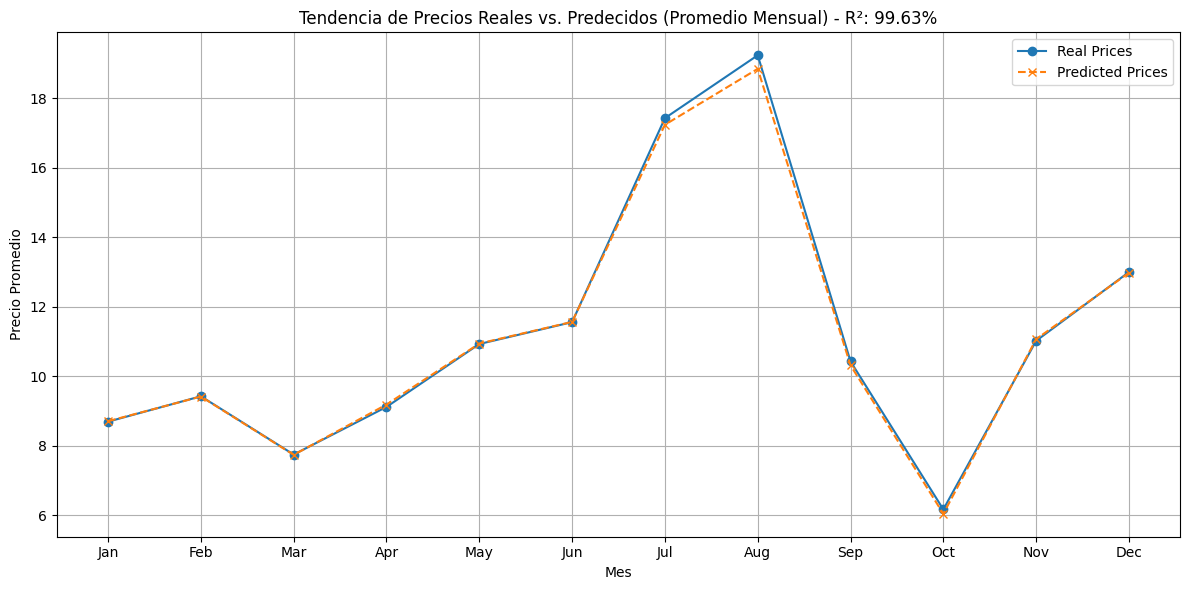

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_real_prices.index, df_real_prices.values, label='Real Prices', marker='o', linestyle='-')
plt.plot(df_pred_prices.index, df_pred_prices.values, label='Predicted Prices', marker='x', linestyle='--')

plt.title('Tendencia de Precios Reales vs. Predecidos (Promedio Mensual) - R²: 99.63%')
plt.xlabel('Mes')
plt.ylabel('Precio Promedio')
plt.xticks(ticks=df_real_prices.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Por Q

In [ ]:
#Dar formato fecha
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

In [ ]:
quarters = [(1, 3), (4, 6), (7, 9), (10, 12)]
q = 1
for quarter in quarters:
    start_month, end_month = quarter
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        ((df_spy_2023['quote_date'].dt.month >= start_month) & (df_spy_2023['quote_date'].dt.month <= end_month))
    )
    df_spy_2023_q = df_spy_2023[conditions]

    X_test_2023_q = df_spy_2023_q[features_cols]
    y_test_2023_q = df_spy_2023_q[target_test]

    y_pred_log_best_q = best_model.predict(X_test_2023_q)

    # Destransformar predicciones
    y_pred_best_q = np.expm1(y_pred_log_best_q)

    print(f"***** Backtesting Q{q} *****")
    print("MAE:", mean_absolute_error(y_test_2023_q, y_pred_best_q))
    print("RMSE:", mean_squared_error(y_test_2023_q, y_pred_best_q))
    print("R²:", r2_score(y_test_2023_q, y_pred_best_q))
    print()
    q += 1

***** Backtesting Q1 *****
MAE: 0.47181098388099435
RMSE: 1.471611141688254
R²: 0.9923319646232885

***** Backtesting Q2 *****
MAE: 0.37733722607882453
RMSE: 0.6804211950494765
R²: 0.9976784186028355

***** Backtesting Q3 *****
MAE: 0.5999817389632572
RMSE: 1.872086402208379
R²: 0.9968736236272163

***** Backtesting Q4 *****
MAE: 0.3967257641833324
RMSE: 1.2381122251268655
R²: 0.9957165423237686



### Por Mes

In [ ]:
m = 1
for month in range(1, 13):
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        (df_spy_2023['quote_date'].dt.month == month)
    )
    df_spy_2023_m = df_spy_2023[conditions]

    X_test_2023_m = df_spy_2023_m[features_cols]
    y_test_2023_m = df_spy_2023_m[target_test]

    y_pred_log_best_m = best_model.predict(X_test_2023_m)

    # Destransformar predicciones
    y_pred_best_m = np.expm1(y_pred_log_best_m)

    print(f"***** Backtesting Mes {m} *****")
    print("MAE:", mean_absolute_error(y_test_2023_m, y_pred_best_m))
    print("RMSE:", mean_squared_error(y_test_2023_m, y_pred_best_m))
    print("R²:", r2_score(y_test_2023_m, y_pred_best_m))
    print()
    m += 1

***** Backtesting Mes 1 *****
MAE: 0.41496281613825775
RMSE: 0.8414094025886466
R²: 0.9951981998083973

***** Backtesting Mes 2 *****
MAE: 0.47135313793288164
RMSE: 1.8431533764276309
R²: 0.9913741476760517

***** Backtesting Mes 3 *****
MAE: 0.5245360327032914
RMSE: 1.74003662982157
R²: 0.9907302641982095

***** Backtesting Mes 4 *****
MAE: 0.29755458915352034
RMSE: 0.49716132951672753
R²: 0.9978718073423684

***** Backtesting Mes 5 *****
MAE: 0.43669319890449165
RMSE: 0.9105933934791014
R²: 0.9968282453620478

***** Backtesting Mes 6 *****
MAE: 0.37540993948150386
RMSE: 0.5763075000650613
R²: 0.9983164400875166

***** Backtesting Mes 7 *****
MAE: 0.5615402009570026
RMSE: 1.2872938233777458
R²: 0.9976783737984776

***** Backtesting Mes 8 *****
MAE: 0.7629176074047622
RMSE: 3.0217665876265665
R²: 0.9959257424118709

***** Backtesting Mes 9 *****
MAE: 0.3906867056959451
RMSE: 0.8076374151137857
R²: 0.9978706115309816

***** Backtesting Mes 10 *****
MAE: 0.35448515294432376
RMSE: 1.40643

## Graficas

In [ ]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)

,0
mc_price,0.622448
moneyness,0.347763
c_delta,0.025057
c_theta,0.002781
iv_skew,0.001062
c_gamma,0.000392
c_iv,0.000165
c_vega,0.000120
dte_year,0.000113
iv_pct_rank,0.000063


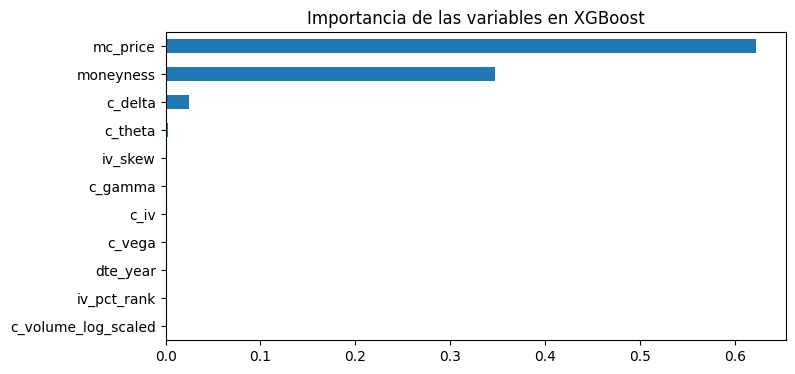

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 4))
plt.title("Importancia de las variables en XGBoost")
plt.show()

## Conclusiones

- R² ≈ 99.26% → el modelo generaliza bien.
- La variable con mayor importancia en el modelo es moneyness.
- Las relaciones en 2023 siguen el comportamiento historico de los 3 ultimos años, el modelo se adapta bien.
- moneyness domina → correcto (S/K controla la convexidad del payoff).
- delta fuerte → correcto (afecta sensibilidad del precio de la opcion respecto al precio del subyacente).
- skew, theta, vega → capturan micro-comportamientos.

**Los resultados del modelo:**
- MAE ≈ 0.62
  - Esto significa que en promedio el modelo se equivoca 62 dólares por contrato (≈ 0.62, sesenta y dos centavos por prima), lo cual es poco eficiente en general.
- RMSE ≈ 2.65
- R² ≈ 0.9926
  - Esto indica que el modelo explica gran parte de la variabilidad del precio.

Sí es razonable para opciones americanas SPY (mucha microestructura, volatilidad, saltos).
- *Incluso los market makers profesionales trabajan con errores absolutos similares cuando no usan el order book directo. SIN EMBARGO, INTERPRETACION:

- **MAE** = 0.6235 -> **En prima:** Error promedio de 62 centavos -> **En contrato  (×100):** Error promedio de $62.35.

- **RMSE** = 2.65 -> **En prima:** Error típico grande de 2.65 dolares -> **En contrato  (x100):** Error promedio de $265 por contrato.

**Conclusion**
- Los resultados de MAE y RMSE son aceptables si el objetivo es determinar el valor Teorico de la opcion (prima).
- El modelo explica gran parte de la variabilidad del precio, pero es ineficiente al momento de determinar el precio real de una opcion.


- Si el **Objetivo es determinar el valor Real de la opcion (prima)** el MAE deberia ser <= 0.10 (10 centavos de dolar en valor de la prima). Ojo esto Difícil pero no imposible llegar a ese MAE, Actualmente no hay modelos que lleguen a ese nivel tan bajo de MAE.

**A nivel académico:***
- Modelos de deep learning de última generación (LSTMs, Transformers, DNN + LSV):
  - MAE ≈ 0.20–0.40 sobre el mid price.
- Sobre last price:
  - MAE ≈ 0.40–1.20

**En bancos y market makers (información no pública pero estandarizada):**
- Para activos muy líquidos (SPY, QQQ):
  - MAE ~ 0.15–0.40 sobre mid
  - MAE ~ 0.30–1.00 sobre last

**Menos líquido:**
- MAE > 1.0 es normal.

**MI HIPOTESIS (PROBARLO):**
- Como pienso aplicar swing-trading (periodos cortos de 3 a 9 dias de trading), podria probar eliminando precios (primas iliquidas), probar entrenar modelo por ITM (menos liquidez) y el mismo modelos pero solo con OTM (mas liquidez).

**Predomina la feature moneyness porque:**

De hecho, de acuerdo al modelo de Black-Scholes:

**Black-Scholes** = f(S,K,T, sigma, r)

- S = Subyacent price
- K = Strike
- T = dte_year
- sigma = c_iv
- r (tasa libre de riesgo) = se puede ignorar para opciones ultracortas.

**Features Optimos del modelo:**
- **moneyness** = S / K
- **dte_year** = T (tiempo de vencimiento en escala de un año)
- **c_iv** = sigma

In [ ]:
# Finished!